In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam

import plotly.express as px
import gc

# Define an early-stopping callback
cb = [EarlyStopping(monitor='val_loss',patience = 2)]

In [2]:
df = pd.read_csv('../../Data/Training/pair_features_updated_300_20.csv')
# df['pnls'] = df['pnls']*100.0
df.head()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries,days_till_first_entry,both_legs_profited,SPY_return,successful_pair_trading
0,2015-01-02,MMM,119.195663,AKAM,63.250000,165.080002,63.900002,162.729996,62.520000,2116400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.708604,False
1,2015-01-05,MMM,116.507500,AKAM,61.939999,163.639999,62.340000,160.080002,60.759998,3692900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.546708,False
2,2015-01-06,MMM,115.265114,AKAM,60.669998,161.369995,62.189999,157.740005,60.099998,3532000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.121924,False
3,2015-01-07,MMM,116.100647,AKAM,60.160000,160.279999,60.959999,158.940002,59.930000,3081300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.883259,False
4,2015-01-08,MMM,118.883270,AKAM,61.570000,163.690002,61.860001,160.520004,60.599998,3142900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.169939,False


# Generate data for LSTM

In [3]:
ticker_pairs = df[['Ticker_P1','Ticker_P2']].drop_duplicates().reset_index(drop=True)

In [4]:
date = []
tk1 = []
tk2 = []
pnls = []
label = []
abs_spread = []

In [5]:
for k in range(ticker_pairs.shape[0]):
    ticker1=ticker_pairs.Ticker_P1[k]
    ticker2=ticker_pairs.Ticker_P2[k]
    
    df_sub = df[
        (df.Ticker_P1 == ticker1)&(df.Ticker_P2 == ticker2)
    ][['Date',
       'Close_P1', 
       'Close_P2', 
       'pnls', 
       'both_legs_profited',
       'successful_pair_trading']].dropna().sort_values('Date', ascending=True).reset_index(drop=True)
    
    for i in range(300, df_sub.shape[0]):
        temp = df_sub.loc[(i-300):i]
        vec = abs(temp.Close_P1 - temp.Close_P2)
        abs_spread.append(vec)
        pnls.append(df_sub.pnls[i])
        label.append(df_sub.both_legs_profited[i]=='True')
        date.append(df_sub.Date[i])
        tk1.append(ticker1)
        tk2.append(ticker2)

In [6]:
# abs_spread = np.array(abs_spread)

In [7]:
train = pd.DataFrame()
train['Date'] = date
train['stock1'] = tk1
train['stock2'] = tk2
train['label'] = label
train['abs_spread'] = abs_spread
# Sort the df by date to ensure the train test split doesn't cause leak
train = train.sort_values('Date', ascending=True).reset_index(drop=True)

In [8]:
np.mean(train.label)

0.13287540447890303

In [9]:
del df
gc.collect()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train['abs_spread'], train['label'], test_size=0.2, shuffle=False)

In [11]:
X_train = np.array([x for x in X_train])
X_test = np.array([x for x in X_test])

In [12]:
scaler = StandardScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [13]:
X_train.shape

(624260, 301)

In [15]:
del train
gc.collect()

0

# Modeling

In [27]:
# Define the input shape (61 time steps with 1 feature per step)
input_shape = (301, 1)

# Create the Sequential model
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))

# model.add(LSTM(100, input_shape=input_shape, return_sequences=True))
# model.add(LSTM(100, input_shape=input_shape, return_sequences=True))
model.add(Bidirectional(LSTM(100,return_sequences=False, dropout=0.2, recurrent_dropout=0.2)))

# model.add(LSTM(100, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(50, activation='relu'))

# Add a Dense layer to output one value
model.add(Dense(1))

# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# Summary of the model
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 299, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 149, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 200)            │       132,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,357 (556.08 KB)

 Trainable params: 142,357 (556.08 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
cb = [EarlyStopping(monitor='val_loss',patience = 2)]

In [32]:
model.fit(scaled_X_train, np.array(y_train), validation_split=0.2,epochs=3, batch_size=32, callbacks=cb)

Epoch 1/2
15607/15607 ━━━━━━━━━━━━━━━━━━━━ 1857s 119ms/step - loss: 2.1043 - val_loss: 2.0545
Epoch 2/2
15607/15607 ━━━━━━━━━━━━━━━━━━━━ 1933s 124ms/step - loss: 2.0949 - val_loss: 2.0545


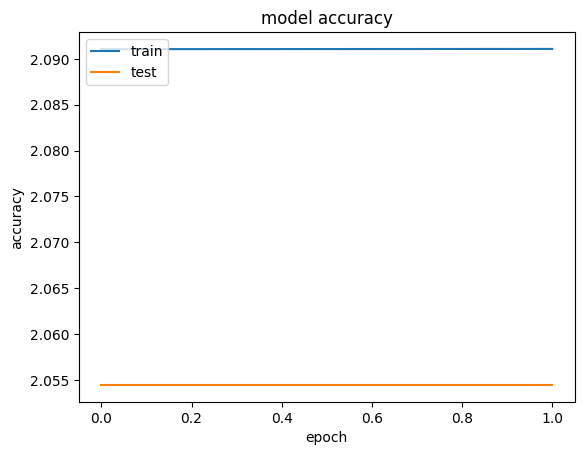

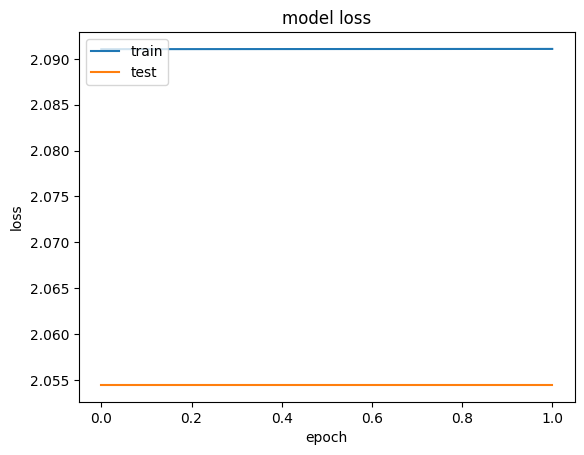

In [33]:
plt.figure(0)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# loss
plt.figure(1)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Scoring

In [34]:
preds = model.predict(scaled_X_test)
preds = [x[0] for x in preds]
preds_bin = np.array(preds)>0.5

4878/4878 ━━━━━━━━━━━━━━━━━━━━ 153s 31ms/step


In [35]:
np.mean(preds_bin)

0.0

In [36]:
np.mean(y_test)

0.14727197001249479

In [37]:
print(f1_score(y_test, preds_bin, average='weighted'))
print(f1_score(y_test, preds_bin, average='micro'))
print(f1_score(y_test, preds_bin, average='macro'))

print(precision_score(y_test, preds_bin))
print(recall_score(y_test, preds_bin))

0.784945314538449
0.8527280299875052
0.4602553727182807
0.0
0.0


/Users/xiaoma/Library/Caches/pypoetry/virtualenvs/pair-trading-foundations-SdobHK0C-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


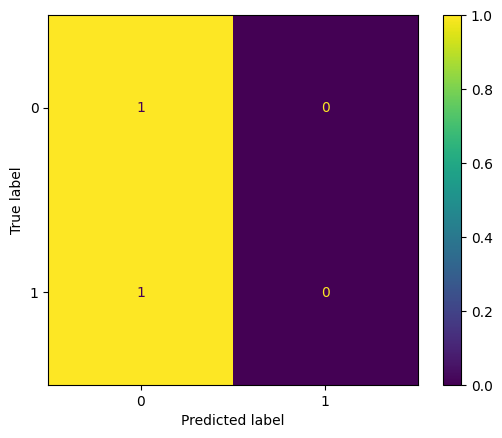

In [38]:
cm = confusion_matrix(y_test, preds_bin,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Save the model